# Dataset restrictions

The purpose of this notebook is to explore the limits of the OpenPose model. 

## Contents

- [Exposure](#Exposure)
- [Resolution](#Resolution)

In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from skimage import exposure, transform, exposure

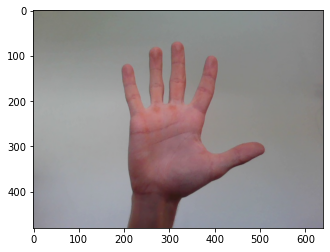

In [2]:
frame = cv2.imread("test_images/5.jpg")
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

In [3]:
protoFile = "openpose/pose_deploy.prototxt"
weightsFile = "openpose/pose_iter_102000.caffemodel"
net = cv2.dnn.readNetFromCaffe(protoFile, weightsFile)

## Exposure

One thing which can vary in many datasets is the exposure of the images. Now we can see what results the OpenPose model gives when we change the exposure of the test image. In this test we will change the exposure of the image by adjusting the gamma. The gamma will be in a range of 0.1 and 4.0 were 0.1 makes the images almost completely white, and 4.0 makes the image black. We can increment the gamma and predict the points. Then we can get the probablility of all the points of that image. The probablility is how confident the algorithm is, which means that the higher the better. Then we can plot all these probablilities in a graph to see the correlation. 

In [4]:
frameCopy = np.copy(frame)
probs = []
for g in range(1, 41):
    gamma_corrected  = exposure.adjust_gamma(frameCopy, g/10)
    inpBlob = cv2.dnn.blobFromImage(gamma_corrected, 1.0 / 255, (640, 480),
                          (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    arr = []
    for i in range(21):
        probMap = output[0, i, :, :]
        probMap = cv2.resize(probMap, (640, 480))
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        arr.append(prob)
    probs.append(np.asarray(arr).mean())

In the graph below we can see that at both ends the probability goes down. This is expected because the image becomes more black or white the higher of lower you set the gamma. And we can see that around a gamma of '1.2' and '2.3' there is a bump. So it would be safe to say that the exposure of the images in the dataset should be between '1' and '2.5'.

Text(0, 0.5, 'probablility')

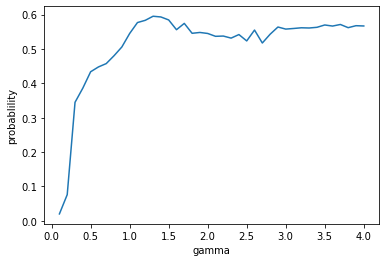

In [5]:
sns.lineplot(x=np.arange(0.1, 4.1, 0.1), y=probs)
plt.xlabel('gamma')
plt.ylabel('probablility')

In the graph above we can see that there is a bump at around '1.2' and '2.3'. For this example we will take the gamma of '1.2' because we can assume that it will give better results because the hand will be more visible. For this image we can plot the histogram and cumulative distribution. Cumulative distribution function is method to describe the distribution of random variables. We can use this to see the distrobution of all the color channels. With data you might choose to also pre-process the images if the initial results were not good.

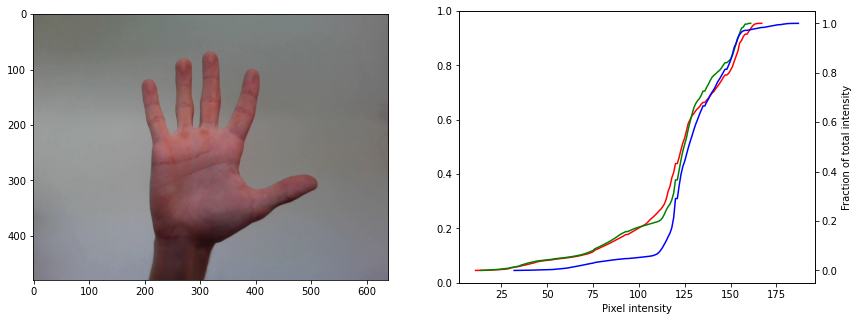

In [14]:
frameCopy = np.copy(frame)
gamma_adjusted  = exposure.adjust_gamma(frameCopy, 1.2)

bins = 256
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
ax_img, ax_hist = axes
ax_cdf = ax_hist.twinx()
ax_hist.set_xlabel('Pixel intensity')
ax_img.imshow(cv2.cvtColor(gamma_adjusted, cv2.COLOR_BGR2RGB))
ax_cdf.set_ylabel('Fraction of total intensity')
img_cdf, bins = exposure.cumulative_distribution(gamma_adjusted[:,:,0], bins)
ax_cdf.plot(bins, img_cdf, 'r')
img_cdf, bins = exposure.cumulative_distribution(gamma_adjusted[:,:,1], bins)
ax_cdf.plot(bins, img_cdf, 'g')
img_cdf, bins = exposure.cumulative_distribution(gamma_adjusted[:,:,2], bins)
ax_cdf.plot(bins, img_cdf, 'b')

## Resolution

Another factor for datasets is the resulution of the images. We can assume that higher resolution images will preform better than lower ones. But this test is more to find out what the minimal resolution is which the OpenPose can predict. 

In [8]:
frameCopy = np.copy(frame)
scales = []
for s in np.flip(np.arange(0.02, 1.02, 0.02)):
    image_rescaled = cv2.resize(frameCopy, (int(frameCopy.shape[1]*s),int(frameCopy.shape[0]*s)))
    size = (image_rescaled.shape[1],image_rescaled.shape[0])
    inpBlob = cv2.dnn.blobFromImage(image_rescaled, 1.0, size,
                              (0, 0, 0), swapRB=False, crop=False)
    net.setInput(inpBlob)
    output = net.forward()
    arr = []
    for i in range(21):
        probMap = output[0, i, :, :]
        minVal, prob, minLoc, point = cv2.minMaxLoc(probMap)
        arr.append(prob)
    scales.append(np.asarray(arr).mean())

Just like before we get the probability of each of the images. Every time we scale the images down by a factor of '0.2'. In the graph below we can see the confidence stays around '0.7' between '1.0' and '0.6'. Then the the probablility spikes up, one reason for why this is is because the OpenPose algorithm has been trained with image of this scale. Which means that it might be better at predicting at this size. After that the line goes down steeply. Until it flattens out at around '0.0'. The red line indicates the theshold for the probability. When i trained i set this threshold at '0.1'. This means that i did not accept a prediction where the probablility is smaller than '0.1'. And the scale factor is around '0.18', this indicates that the scale factor can be at least '0.18' before the probablility becomes too small.  

Text(0, 0.5, 'probablility')

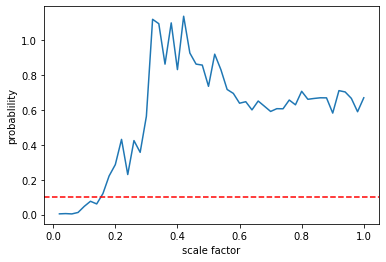

In [9]:
sns.lineplot(x=np.flip(np.arange(0.02, 1.02, 0.02)), y=scales)
plt.axhline(y=0.1, color='red', linestyle='--')
plt.xlabel('scale factor')
plt.ylabel('probablility')

The resolution of the image will be '115 'by '86' if we scale the image down with a factor of '0.18'. But we need to keep in mind that the hand is only a small part of the image. So, in this case the resolution of the hand is only about '60' by '60'. And because the in an image can be at any size it would be better to recommend that the hand inside the image is no smaller than '60' by '60' pixels.

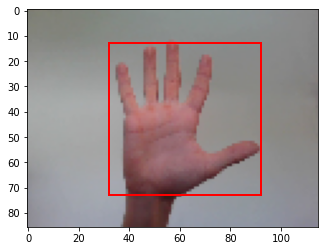

In [10]:
import matplotlib.patches as patches

rescale = cv2.resize(frameCopy, (int(frameCopy.shape[1]*0.18),int(frameCopy.shape[0]*0.18)))
fig, ax = plt.subplots()
ax.imshow(cv2.cvtColor(rescale, cv2.COLOR_BGR2RGB))
rect = patches.Rectangle((32, 13), 60, 60, linewidth=2, edgecolor='r', facecolor='none')
ax.add_patch(rect)
plt.show()